<!--<center>
  <h1>PROJET ARF</h1>
  <h1>2018-2019</h1>
  <img src="https://i.ibb.co/hY0bzWY/SORBONNE-FAC-SCIENCES-DEF-CMJN.png" alt="SORBONNE-FAC-SCIENCES"  width="20%" >
  <h2>Abdelraouf KEKES</h2>
  <h2>Ilyas AROUI</h2>
</center> -->


# Machine Learning Project
# 2018-2019
## Abdelraouf KEKES
## Ilyas AROUI

# Introduction:


The task of ** Inpainting ** in Computer Vision is well known and widely used in this field. It consists in automatically filling the missing pixels in an image .
There are two approaches in the literature. An example-based approach that searches for the nearest patch in the intact region of the patch containing the missing pixels. The nearest one is defined by a distance, for example, in [3], they used a simple eucildian distance. On the other hand, in the PDE (Partially Differential Equations) approach, they fill the missing part step by step from the bounds to the center of the distortion.
In this project, we will implement the algorithm used in [1] that adapts the Lasso regression to predict the missing pixels by using the intact pixels of the same patch. The idea behind Lasso is to limit the representation of pixels to those who are similar. In other words, instead of intuitively averaging all the patches in the dictionary. Lasso will help us use only the patches necessary for the consistent and harmonious filling of the missing pixels by favoring the relevant parameters and penalizing the irrelevant ones throughout the learning process

Thus, this notebook will discuss the advantages of the Lasso regression compared to the Ridge regression in the first part, then in a second part, we will implement the algorithm presented in [1].


## Imports

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import cv2

from matplotlib.colors import hsv_to_rgb , rgb_to_hsv
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import axes3d, Axes3D
import seaborn as sns
sns.set(palette="bright")

import gc 
import time

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score

In [2]:
# if (GOOGLE COLAB) run this cell !

from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive/Colab Notebooks 


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks


<u><i> <h1>Preambule</h1></i></u>



<h2 style="color:red;" >Experimental Protocol</h2>

 **Functions :**

In [0]:
def load_usps(fn):
    with open(fn,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp=np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="gray")

def preprocess_USPS_data( Xtrain  , Ytrain , Xtest , Ytest ,  class1 , class2 , bias=False ):
  
  '''
  - class 1 int 
  - class 2 int or 'all'
  - bias == True   add a bias column to X
  '''
  
  if ( class2 == "all" ):
    X_train_indices , X_test_indices  = np.arange(len(Ytrain)) , np.arange(len(Ytest))
  else :
    X_train_indices = ( np.isin ( Ytrain , [class1,class2]  ) )
    X_test_indices  = ( np.isin ( Ytest  , [class1,class2]  ) )
  
  X_train, Y_train = Xtrain [ X_train_indices ] , np.where ( Ytrain [ X_train_indices ] == class1 , 1 , 0 )
  X_test , Y_test  = Xtest  [ X_test_indices  ] , np.where ( Ytest  [ X_test_indices  ] == class1 , 1 , 0 )
  
  if ( bias ):
    X_train = np.append ( X_train , np.ones( (X_train.shape[0],1) ) , axis=1 )
    X_test  = np.append ( X_test  , np.ones( (X_test.shape[0],1) )  , axis=1 )
    
  print("classes confirmation :",np.unique(Ytrain [ X_train_indices ]))

  return X_train , Y_train , X_test , Y_test

**Fetching Data**

In [0]:
Xtrain , Ytrain  = load_usps ("USPS_train.txt")
Xtest , Ytest    = load_usps ("USPS_test.txt")

**Normalization**

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

print("maximum pixel intensity : ",np.amax(Xtrain)) 
print("minimum pixel intensity : ",np.amin(Xtrain))

maximum pixel intensity :  1.0
minimum pixel intensity :  0.0


In [0]:
X_6vs9_train , Y_6vs9_train , X_6vs9_test , Y_6vs9_test =  preprocess_USPS_data( Xtrain  , Ytrain , Xtest , Ytest ,  6 , 9 )
X_3vs8_train , Y_3vs8_train , X_3vs8_test , Y_3vs8_test =  preprocess_USPS_data( Xtrain  , Ytrain , Xtest , Ytest ,  3 , 8 , True )
X_5vsall_train , Y_5vsall_train , X_5vsall_test , Y_5vsall_test =  preprocess_USPS_data( Xtrain  , Ytrain , Xtest , Ytest ,  5 , 'all' , True )

classes confirmation : [6 9]
classes confirmation : [3 8]
classes confirmation : [0 1 2 3 4 5 6 7 8 9]


**Dimentiality Confirmation**

In [0]:
print("whole train data and labels shapes : ",Xtrain.shape, Ytrain.shape ) 
print("whole test data and labels shapes : ",Xtest.shape, Ytest.shape  )
print("------------------------------------------")
print("6 Vs 9 train and labels shapes :",X_6vs9_train.shape, Y_6vs9_train.shape)
print("6 Vs 9 test and labels shapes :",X_6vs9_test.shape, Y_6vs9_test.shape)
print("------------------------------------------")
print("3 Vs 8 train and labels shapes :",X_3vs8_train.shape, Y_3vs8_train.shape)
print("3 Vs 8 test and labels shapes :",X_3vs8_test.shape, Y_3vs8_test.shape)
print("------------------------------------------")
print("5 Vs all train and labels shapes :",X_5vsall_train.shape, Y_5vsall_train.shape)
print("5 Vs all test and labels shapes :",X_5vsall_test.shape, Y_5vsall_test.shape)
print("------------------------------------------")

whole train data and labels shapes :  (7291, 256) (7291,)
whole test data and labels shapes :  (2007, 256) (2007,)
------------------------------------------
6 Vs 9 train and labels shapes : (1308, 256) (1308,)
6 Vs 9 test and labels shapes : (347, 256) (347,)
------------------------------------------
3 Vs 8 train and labels shapes : (1200, 257) (1200,)
3 Vs 8 test and labels shapes : (332, 257) (332,)
------------------------------------------
5 Vs all train and labels shapes : (7291, 257) (7291,)
5 Vs all test and labels shapes : (2007, 257) (2007,)
------------------------------------------


In [0]:
np.random.seed(1995)

## Explore The plug-in approach power : 

Let $f_ {w}$ be the prediction function and  $ y $  be the set of true labels of the training set.


### 1) Linear Regression

We want to minimize this cost function : 

$L_{MSE}(w)= \frac{1}{2N}\sum_{i=1}^{N}(y_{i} - f_{w}(x_{i})))^{2}$

We will optimize it using the gradient descent algorithm : 

$\frac{\partial L_{MSE}}{\partial w} = \frac{1}{N}\sum_{i=1}^{N}(y_{i} - f_{w}(x_{i})))x_{i}$


**6 VS 9 :**

### Note

The bias is already taken into account in the weights vector since we have added a column of ones to X.
Consequently , the argument **fit_intercept** is set to **False**

In [0]:
clf1 = linear_model.LinearRegression(fit_intercept= False).fit(X_6vs9_train , Y_6vs9_train)

In [0]:
# np.sign  return -1 , 1   and 0  if 0  and at the end we just need 1 , 0 outputs for MSE loss  so  we don t need  np.sign in our case

res1 =  np.where ( clf1.predict (X_6vs9_train) >=0 , 1 , 0 ) 
res11 = np.where ( clf1.predict (X_6vs9_test) >=0 , 1 , 0 ) 

print("accuracy Linear Regression Plug-in ( 6 VS 9 ) on train : ",(res1 == Y_6vs9_train).mean())
print("\naccuracy Linear Regression Plug-in ( 6 VS 9 ) on test  : ",(res11  == Y_6vs9_test).mean())
print("\nf1-score: ",f1_score(Y_6vs9_test, res11))


accuracy Linear Regression Plug-in ( 6 VS 9 ) on train :  0.7438837920489296

accuracy Linear Regression Plug-in ( 6 VS 9 ) on test  :  0.7377521613832853

f1-score:  0.7878787878787878


**3 VS 8 :**

In [0]:
clf1 = linear_model.LinearRegression(fit_intercept= False).fit( X_3vs8_train , Y_3vs8_train )

In [0]:
res1 =  np.where ( clf1.predict (X_3vs8_train) >=0 , 1 , 0 ) 
res11 = np.where ( clf1.predict (X_3vs8_test) >=0 , 1 , 0 ) 

print("accuracy Linear Regression Plug-in ( 3 VS 8 ) on train : ",(res1 == Y_3vs8_train).mean())
print("\naccuracy Linear Regression Plug-in ( 3 VS 8 ) on test  : ",(res11  == Y_3vs8_test).mean())
print("\nf1-score: ",f1_score(Y_3vs8_test, res11))


accuracy Linear Regression Plug-in ( 3 VS 8 ) on train :  0.7083333333333334

accuracy Linear Regression Plug-in ( 3 VS 8 ) on test  :  0.6746987951807228

f1-score:  0.7534246575342466


**5 VS All :**

In [0]:
clf1 = linear_model.LinearRegression(fit_intercept= False).fit( X_5vsall_train , Y_5vsall_train )

In [0]:
res1 =  np.where ( clf1.predict (X_5vsall_train) >0 , 1 , 0 ) 
res11 = np.where ( clf1.predict (X_5vsall_test)  >0 , 1 , 0 ) 

print("accuracy Linear Regression Plug-in ( 5 VS all ) on train : ",(res1 == Y_5vsall_train).mean())
print("\naccuracy Linear Regression Plug-in ( 5 VS all ) on test  : ",(res11  == Y_5vsall_test).mean())
print("\nf1-score: ",f1_score( Y_5vsall_test, res11))


accuracy Linear Regression Plug-in ( 5 VS all ) on train :  0.4335482101220683

accuracy Linear Regression Plug-in ( 5 VS all ) on test  :  0.45241654210264076

f1-score:  0.2255109231853418


**Improvisation : Multi Class Regression Plug-in Classifier :**


We will try to extend 'the plug-in trick' on a multi-class scale using intervals, as shown in the following formula:

\begin{equation}
    Y =
    \begin{cases}
      0, & \text{if }\ Output <0.5  \\
      1, & \text{if }\ Output \in \left[0.5, 1.5\right[  \\
      2, & \text{if }\ Output \in \left[1.5, 2.5\right[  \\
      3, & \text{if }\ Output \in \left[2.5, 3.5\right[  \\
      4, & \text{if }\ Output \in \left[3.5, 4.5\right[  \\
      5, & \text{if }\ Output \in \left[4.5, 5.5\right[  \\
      6, & \text{if }\ Output \in \left[5.5, 6.5\right[  \\
      7, & \text{if }\ Output \in \left[6.5, 7.5\right[  \\
      8, & \text{if }\ Output \in \left[7.5, 8.5\right[  \\
      9, & \text{if }\ Output \ge 8.5  \\
    \end{cases}
  \end{equation}

In [0]:
clf = linear_model.LinearRegression(fit_intercept= False).fit( Xtrain , Ytrain )

In [0]:
outputs_tr , outputs_ts = clf.predict(Xtrain) , clf.predict(Xtest)

In [0]:
thresholds = np.append ( np.arange ( 0.5 , 9.5 , 1 ) ,np.array([np.Inf]) )

thresholds

array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, inf])

In [0]:
#Confirmation 
for val in [ -4 , 0.49 , 0.5 , 3.6 , 8.49 , 8.5 , 50 ] : 
    print("if pred = ",val," encoded pred is going to be " , np.argmax(thresholds>val) )

if pred =  -4  encoded pred is going to be  0
if pred =  0.49  encoded pred is going to be  0
if pred =  0.5  encoded pred is going to be  1
if pred =  3.6  encoded pred is going to be  4
if pred =  8.49  encoded pred is going to be  8
if pred =  8.5  encoded pred is going to be  9
if pred =  50  encoded pred is going to be  9


In [0]:
Y_tr = np.vectorize ( lambda reg_output : np.argmax(thresholds>reg_output) ) (outputs_tr)
Y_ts = np.vectorize ( lambda reg_output : np.argmax(thresholds>reg_output) ) (outputs_ts)

In [0]:
np.unique ( np.append(Y_tr,Y_ts) )

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [0]:
print("accuracy Multi Linear Regression Plug-in on train : ",(Y_tr == Ytrain).mean())
print("accuracy Multi Regression Plug-in on test  : ",(Y_ts  == Ytest).mean())

accuracy Multi Linear Regression Plug-in on train :  0.2645727609381429
accuracy Multi Regression Plug-in on test  :  0.2526158445440957


**Confusion Matrix**

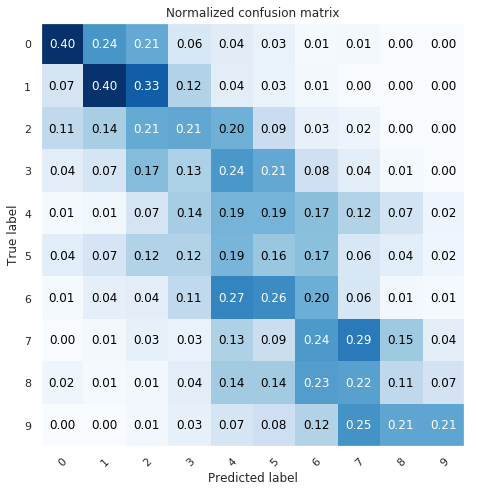

In [0]:
# Compute confusion matrix
cm = confusion_matrix(Ytest, Y_ts)
# Normalize
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# Only use the labels that appear in the data
classes = np.arange(10)
fig, ax = plt.subplots(figsize=(7,7))
ax.grid(False)
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title="Normalized confusion matrix",
       ylabel='True label',
       xlabel='Predicted label')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

## Discussing plug-in approch with Linear Regression

- We notice that the linear regression as its name indicates is not very suitable to the classification tasks , and even  with the "plug-in trick" its performances are limited and inversely proportional to the complexity of the problem ie: "The more classification problem gets more complex the lower the performance"

  - 6 VS 9  ==> accuracy =  0.74
  - 5 VS All ==> accuracy  = 0.45
  - Multi Class ( approche intervales  )  ==> accuracy = 0.25 
  
- This is due to the nature of the MSE loss function which considers any predicted value different from the exact true label as a false value . In fact ,  for a point with a label -1, a predictor predicting -3 or +1 for the MSE loss is the same and it is an error of length 2 to correct whereas -3 is supposed to be a very good answer in a classification binary for a real label = -1 !

- Regarding our interval-based multi-class classifier We also find that for each class we have an average error interval of 4 classes, for example:
  - Classe 0 : confusion between 0 , 1 ,  2 , 3
  - Classe 1 : confusion between   1 , 2 , 3
  - Classe 2 : confusion between   1 , 2 , 3 , 4 , 5  and so forth .
  
These results are due to the false ' intervals ' assumption that we have fixed based on the linear regression with MSE Loss

**BACK TO 6 VS 9**

In [0]:
clf1 = linear_model.LinearRegression(fit_intercept= False).fit( X_6vs9_train , Y_6vs9_train )

### 2) Ridge Regression

$L_{MSE}(w)= \frac{1}{2N}\sum_{i=1}^{N}(y_{i} - f_{w}(x_{i})))^{2}+ \beta \sum w_{j}^2$
<br>
<br>
$\frac{\partial L_{MSE}}{\partial w} = \frac{1}{N}\sum_{i=1}^{N}(y_{i} - f_{w}(x_{i})))x_{i}+ 2 \beta w $

**Grid Search on alpha (Tuning)**

In [0]:
%%capture

parameters = {'alpha':[1000 , 100 , 10 , 1 , 0.9 , 0.8 , 0.7 , 0.6 , 0.5 , 0.4 , 0.3 , 0.2 , 0.1 , 0.01 , 0.001 , 0.0001 ]}
crossV = GridSearchCV( linear_model.Ridge( max_iter=50000 )  , parameters, cv=5 , return_train_score=True )
crossV.fit( X_6vs9_train , Y_6vs9_train )

In [0]:
results   = { k : crossV.cv_results_[k] for k in ['params','mean_test_score','rank_test_score'] }
pd.DataFrame(results)

,params,mean_test_score,rank_test_score
0,{'alpha': 1000},0.899128,14
1,{'alpha': 100},0.932813,2
2,{'alpha': 10},0.936273,1
3,{'alpha': 1},0.929937,3
4,{'alpha': 0.9},0.929563,4
5,{'alpha': 0.8},0.929143,5
6,{'alpha': 0.7},0.928665,6
7,{'alpha': 0.6},0.928109,7
8,{'alpha': 0.5},0.927444,8
9,{'alpha': 0.4},0.926615,9


In [0]:
clf2 = crossV.best_estimator_
y_pred =  np.where ( clf2.predict (X_6vs9_test) >=0 , 1 , 0 ) 
print("accuracy Ridge Regression Plug-in ( 6 VS 9 ) on test  : ",accuracy_score(Y_6vs9_test,y_pred))

accuracy Ridge Regression Plug-in ( 6 VS 9 ) on test  :  0.7002881844380403


**Savings weights and norms** 

In [0]:
weights_ridge = []
norms_ridge   = []

for alpha in [1000 , 100 , 10 , 1 , 0.9 , 0.8 , 0.7 , 0.6 , 0.5 , 0.4 , 0.3 , 0.2 , 0.1 , 0.01 , 0.001 , 0.0001 ]:
  m = linear_model.Ridge( max_iter=50000 , alpha = alpha ).fit(X_6vs9_train,Y_6vs9_train)
  weights_ridge.append ( m.coef_ )
  norms_ridge.append ( np.linalg.norm(m.coef_) )
  
  
weights_ridge = np.array(weights_ridge)
norms_ridge   = np.array(norms_ridge)

### 3) LASSO Regression

$L_{MSE}(w)= \frac{1}{2N}\sum_{i=1}^{N}(y_{i} - f_{w}(x_{i})))^{2}+\alpha\sum  \left | w_{j} \right |  $
<br>
<br>

\begin{equation}
    \frac{\partial L_{MSE}}{\partial w} =
    \begin{cases}
      \frac{1}{N}\sum_{i=1}^{N}(y_{i} - f_{w}(x_{i})))x_{i}+ \alpha  , & \text{if }\  w_{j} >=0  \\
      \frac{1}{N}\sum_{i=1}^{N}(y_{i} - f_{w}(x_{i})))x_{i} -\alpha  , & \text{if }\  w_{j} <  0  \\
    \end{cases}
  \end{equation}

**Same process as Ridge :**

In [0]:
%%capture

parameters = {'alpha':[1000 , 100 , 10 , 1 , 0.9 , 0.8 , 0.7 , 0.6 , 0.5 , 0.4 , 0.3 , 0.2 , 0.1 , 0.01 , 0.001 , 0.0001 ]}
crossV = GridSearchCV( linear_model.Lasso( max_iter=5000 , tol=0.001 )  , parameters, cv=5 , return_train_score=True )
crossV.fit( X_6vs9_train , Y_6vs9_train )

In [0]:
results   = { k : crossV.cv_results_[k] for k in ['params','mean_test_score','rank_test_score'] }
pd.DataFrame(results)

,params,mean_test_score,rank_test_score
0,{'alpha': 1000},-0.025120,5
1,{'alpha': 100},-0.025120,5
2,{'alpha': 10},-0.025120,5
3,{'alpha': 1},-0.025120,5
4,{'alpha': 0.9},-0.025120,5
5,{'alpha': 0.8},-0.025120,5
6,{'alpha': 0.7},-0.025120,5
7,{'alpha': 0.6},-0.025120,5
8,{'alpha': 0.5},-0.025120,5
9,{'alpha': 0.4},-0.025120,5


In [0]:
clf3 = crossV.best_estimator_
y_pred =  np.where ( clf3.predict (X_6vs9_test) >=0 , 1 , 0 ) 
print("accuracy Lasso Regression Plug-in ( 6 VS 9 ) on test  : ",accuracy_score(Y_6vs9_test,y_pred))

accuracy Lasso Regression Plug-in ( 6 VS 9 ) on test  :  0.6887608069164265


In [0]:
weights_lasso = []
norms_lasso   = []

for alpha in [1000 , 100 , 10 , 1 , 0.9 , 0.8 , 0.7 , 0.6 , 0.5 , 0.4 , 0.3 , 0.2 , 0.1 , 0.01 , 0.001 , 0.0001 ]:
  m = linear_model.Lasso( max_iter=5000 , tol=0.001 , alpha = alpha ).fit(X_6vs9_train,Y_6vs9_train)
  weights_lasso.append ( m.coef_ )
  norms_lasso.append ( np.linalg.norm(m.coef_) )
  
  
weights_lasso = np.array(weights_lasso)
norms_lasso   = np.array(norms_lasso)

**Comparing the three approaches**

**Weights Matrices :**

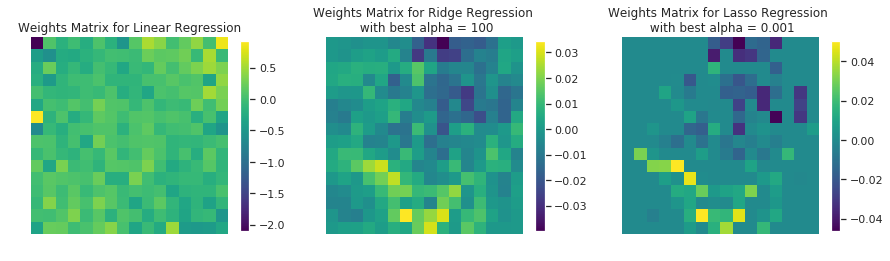

In [0]:
clfs = [clf,clf2,clf3]
titles= ["Weights Matrix for Linear Regression" , "Weights Matrix for Ridge Regression \n with best alpha = "
         +str(clf2.alpha),"Weights Matrix for Lasso Regression \n with best alpha = "+str(clf3.alpha)]

fig , ax = plt.subplots ( nrows=1 , ncols=3 , figsize=(15,5)  )

for i in range(3) : 
  ax[i].set_axis_off()
  ax[i].set_title(titles[i])
  im = ax[i].imshow( clfs[i].coef_.reshape(16,16) , cmap=plt.cm.viridis )
  fig.colorbar(im , ax=ax[i] , shrink=0.70)


plt.show()


**weights norms**

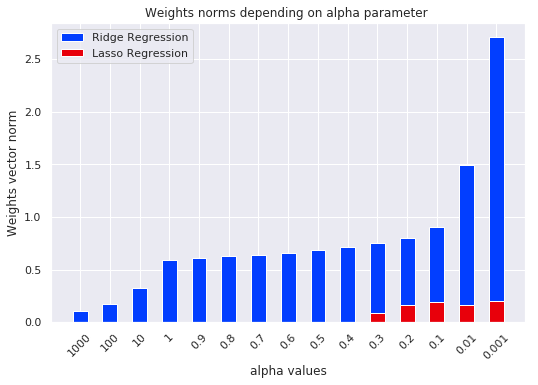

In [0]:
#deleteing 0.0001  for more clearness in plots  ( last element )
X_ticks = [1000 , 100 , 10 , 1 , 0.9 , 0.8 , 0.7 , 0.6 , 0.5 , 0.4 , 0.3 , 0.2 , 0.1 , 0.01 , 0.001 ]
X = np.arange(len(X_ticks))

plt.figure(figsize=(8.5,5.5))

plt.title("Weights norms depending on alpha parameter ")
plt.bar(X, norms_ridge[:-1] , width=0.5, color='b', align='center' , label="Ridge Regression" )
plt.bar(X , norms_lasso[:-1] , width=0.5, color='r', align='center' , label="Lasso Regression" )
plt.legend()
plt.ylabel("Weights vector norm")
plt.xlabel("alpha values")
plt.xticks(X,X_ticks,rotation=45)

plt.show()

In [0]:
# approximative 
Eps = 1e-4
ridge_counts_epsilon = np.count_nonzero ( np.abs(weights_ridge) <= Eps , axis = 1 )
#exact
ridge_counts = np.count_nonzero ( weights_ridge == 0 , axis = 1 )
lasso_counts = np.count_nonzero ( weights_lasso == 0 , axis = 1 )

ridge_counts

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [0]:
ridge_counts_epsilon

array([17,  8,  3,  3,  3,  2,  3,  2,  2,  2,  2,  2,  2,  1,  1,  1])

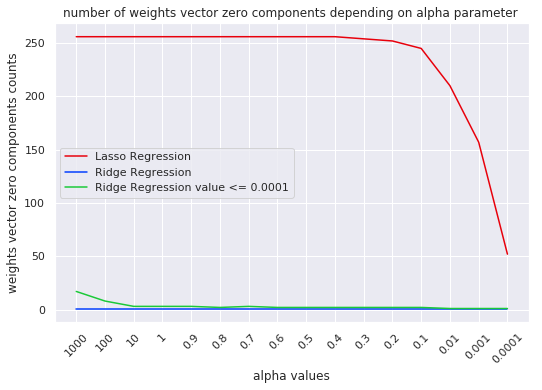

In [0]:
X_ticks = [1000 , 100 , 10 , 1 , 0.9 , 0.8 , 0.7 , 0.6 , 0.5 , 0.4 , 0.3 , 0.2 , 0.1 , 0.01 , 0.001 , 0.0001 ]
X = np.arange(len(X_ticks))

plt.figure(figsize=(8.5,5.5))
sns.color_palette("Paired")
plt.title("number of weights vector zero components depending on alpha parameter ")
plt.plot(X , lasso_counts , color="r" , label="Lasso Regression" )
plt.plot(X , ridge_counts , color="b" , label="Ridge Regression" )
plt.plot(X , ridge_counts_epsilon , color="g" , label="Ridge Regression value <= "+str(Eps) )

plt.legend()
plt.ylabel("weights vector zero components counts")
plt.xlabel("alpha values")
plt.xticks(X,X_ticks,rotation=45)
sns.set(palette="Paired")
plt.show()

<h2 style="color:red;" >Discussing Results </h2>

Overall by analyzing the 3 graphs, we find that:
- **Ridge Regression**: It does not influence the number of zero components of the vector of the weights as a function of alpha. In contrast, the norm of the vectors is inversely proportional to alpha.
- **LASSO Regression**: the number of zero components of the weight vector depends largely on the alpha parameter. On the other hand, the norm does not change too much by varying the latter.

<h2 style="color:red;" >Conclusion </h2>

1) LASSO Regression tries to regularize the weights by finding the best model with few representations ( trade off ). In other words, we can say that it makesa sort of a ' Features Selection '. The latter can therefore even help us interpretability of the model.

2) Furthermore , We can combine the two approaches to form a regularization that takes into account the number of non-zero components as well as the norm of the vector of weights: :
$L_{hybrid}(w) = \frac{1}{2N}\sum_{i=1}^{N}(y_{i} - f_{w}(x_{i})))^{2} + \alpha\sum  \left | w_{j} \right | + \beta \sum w_{j}^2$

<u><i> <h1>Inpainting</h1></i></u>

### Funtions 

In [160]:
def read_im(fn) :
    return plt.imread(fn)/255

def show_im(arr):
    arr3 = arr.copy()
    arr3[arr3 == -100] = 0
    plt.grid(False)
    plt.imshow(arr3)
    #plt.show()
    
def show_imgs_oneline ( img1 , img2 , img3 ): 

    plt.figure(figsize= (15, 80))

    plt.subplot(131)
    show_im(img1)
    plt.title('Original image')

    plt.subplot(132)
    show_im(img2)
    plt.title('Damaged image')

    plt.subplot(133)
    show_im(img3)
    plt.title('Restored image')

    plt.show()
 
    
def delete_rect( im_arr , i , j ,  width , height  ):
    #(i,j) coordinates of upper left corner
    arr_hole = im_arr.copy()
    for ind1 in range ( i , i+height ):
        for ind2 in range ( j , j+width ) :
            arr_hole [ind1,ind2] = np.ones(3)*(-100)
    return arr_hole

def get_patch( im_arr , i , j , h ):
    #(i,j) coordinates of the center of the patch
    start_i , start_j = i-h//2 , j-h//2
    return im_arr[ start_i : start_i+h , start_j : start_j+h , : ].copy()

def fill_patch( im_arr , i , j , h , values):
    start_i , start_j = i-h//2 , j-h//2
    im_arr[ start_i : start_i+h , start_j : start_j+h , : ] = values.reshape(h,h,3)

  
def get_dictionary( arr , h , stride=1):
    dictionary = []
    for i in range (  0 , arr.shape[0] - h , stride ):
        for j in range ( 0 , arr.shape[1] - h , stride ) :
            arr_curr_patch = get_patch( arr , i+h//2 , j+h//2 , h ).ravel()
            hole_pixels = np.argwhere( arr_curr_patch == -100 ).shape[0] > 0
            complete_pixels = np.argwhere( arr_curr_patch != -100 ).shape[0] > 0
            if ( not hole_pixels and complete_pixels ):
                dictionary.append( arr_curr_patch )
    
    return np.array(dictionary).T

def get_boundaries_pixels ( arr ):
    channel =  arr[:,:,0].reshape( arr.shape[0] , arr.shape[1] )
    res = set()
    for i in range (channel.shape[0]):
        for j in range(channel.shape[1]):
            pixel = channel[i,j]
            if ( pixel == -100 ):
                if ( channel[i,j-1]!=-100 or channel[i,j+1]!=-100 or 
                     channel[i-1,j]!=-100 or channel[i+1,j]!=-100 ) : 
                    res.add((i,j))
        
    return res

def naive_high_priority_pixel ( img_arr , h , boundary_pixels ):
    priority = -1 
    prior_pixel = (-1,-1)
    prior_patch = None
    for pixel in boundary_pixels :
        p = get_patch ( img_arr , pixel[0] , pixel[1] , h ).ravel()
        count_px_complete = np.argwhere(p != -100).shape[0]
        if ( count_px_complete > priority ):
            priority = count_px_complete
            prior_pixel = pixel
            prior_patch = p
            
    return prior_pixel , prior_patch
  
  
def noise( im_arr , percent ):
  
  arr_noise = im_arr.copy()
  all_pixels = np.array (np.meshgrid( np.arange( arr_noise.shape[0])+arr_noise.shape[0]//6 ,
                                      np.arange(arr_noise.shape[1])+arr_noise.shape[1]//6 )).T.reshape(-1,2)

  selected_index = np.random.choice( all_pixels.shape[0] , int(percent*all_pixels.shape[0]) , replace=False)  
  for idx in selected_index :
    arr_noise[ all_pixels[idx][0] , all_pixels[idx][1] ] = np.ones(3) * -100 

  return arr_noise
  
import warnings
warnings.filterwarnings("ignore")

## Inpainting

In [161]:
def Inpainting ( img_path , h , stride , i , j , width , height , alpha = 0.001 , max_iter = 50000 ,noise_per = 0.1, Noise=False , verbose=True ):
  
  '''
  a pipeline function to launch the whole inpainting algorithm.
  h : patch size.
  i,j : coordinate of the upper left corner of the object to be removed.
  width : width of object to be removed.
  height: height of object to be removed.
  alpha: Lasso regularization parameter.
  max_iter : number of iteration for the Lasso regression.
  Noise: if True, noise the image and neglect the parameter i, j, height, width.
  verbose: if True, print to the console the training progress.
  
  '''
  t_init = time.time()
  array_img =  read_im(img_path)
  print("image shape : " , array_img.shape )

  #rgb TO hsv
  imgNormalized_hsv = rgb_to_hsv(array_img)
  if ( not Noise ):
    
      img_hole_rgb = delete_rect (  array_img , i , j ,  width , height )
      img_hole = delete_rect (  imgNormalized_hsv , i , j ,  width , height )
      
  else :
      img_hole_rgb = noise (  array_img , noise_per)
      img_hole = noise (  imgNormalized_hsv, noise_per )  
  X = get_dictionary ( img_hole , h , stride )
  print("dictionary shape : " , X.shape )
  
  b_pixels = get_boundaries_pixels ( img_hole )
  
  clf = linear_model.Lasso(alpha=alpha, max_iter=max_iter )
 
  # ALGORITHM 
  i  = 0
  
  while ( len(b_pixels) > 0 ):
      gc.collect()

      
      selected_pixel , Y = naive_high_priority_pixel( img_hole , h , b_pixels )
      Y = Y.ravel()
      train_i = np.argwhere(Y != -100).ravel()
      test_i  = np.argwhere(Y == -100).ravel()
      clf.fit( X[train_i] , Y[train_i]  )
      if ( verbose ) :
        print("iteration ",i," len b_pixel : ",len(b_pixels))
        print("selected pixel : ",selected_pixel)
        print("selected patch shape : ",Y.shape )
        print("number of none zero components: {0:.2f}  %".format(100*np.where ( clf.coef_ != 0 )[0].shape[0]/X.shape[1]))
      Y[test_i] = clf.predict( X[test_i] )
      fill_patch( img_hole , selected_pixel[0] , selected_pixel[1] , h , Y )

      b_pixels = get_boundaries_pixels ( img_hole )

      i += 1

#   #Normalization 
#   H = img_hole[:,:, 0].reshape(img_hole.shape[0], img_hole.shape[1], 1)
#   S = img_hole[:,:, 1].reshape(img_hole.shape[0], img_hole.shape[1], 1)
#   V = img_hole[:,:, 2].reshape(img_hole.shape[0], img_hole.shape[1], 1)
#   H_norm = (H - np.amin(H))/(np.amax(H) - np.amin(H))
#   S_norm = (S - np.amin(S))/(np.amax(S) - np.amin(S))
#   V_norm = (V - np.amin(V))/(np.amax(V) - np.amin(V))
#   img_hole = np.concatenate((H_norm, S_norm, V_norm), axis= -1)
#   #HSV to RGB
  result_rgb = hsv_to_rgb(img_hole)
    
  print("elapsed time: {0:.2f} seconds".format(time.time() - t_init))
  # Plotting résults  
  show_imgs_oneline ( array_img , img_hole_rgb , result_rgb )
 

### Region removal with tuned parameters:

Tuning the algorithm hyper parameters was really time consuming to obtain acceptable and reasonable results. Basically, we had to pay attention to the Dictionary Matrix, making sure to have enough learning examples with:

- X = ($ 3.h ^ {2} $, number of patches)
- Y = ($ 3.h ^ {2} $)
 where $ h $ is patch_size and Y is our noisy signal.

Another aspect we have tried to control is the dimension of the weighting vector, which depends on 3 variables: $ h, stride $ and the size of the missing region.

The latter indicates that the tuning of the parameters is unique for each image. Therefore, we can not define optimal global parameters for the Inpainting problem. The bigger the stride, the fewer patches we get.

Below, we present the result of three different image restorations. The execution time and the percentage of non-zero weights are also indicated.

We find that the smaller the alpha, the greater the number of iterations required, resulting in more learning time.
In addition, the larger the alpha, the lower the weight obtained, because alpha controls the Lasso effect on our loss function.

image shape :  (72, 128, 3)
dictionary shape :  (363, 149)
iteration  0  len b_pixel :  36
selected pixel :  (34, 25)
selected patch shape :  (363,)
number of none zero components: 50.34  %
iteration  1  len b_pixel :  35
selected pixel :  (26, 25)
selected patch shape :  (363,)
number of none zero components: 45.64  %
iteration  2  len b_pixel :  24
selected pixel :  (25, 31)
selected patch shape :  (363,)
number of none zero components: 42.95  %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration  3  len b_pixel :  12
selected pixel :  (33, 34)
selected patch shape :  (363,)
number of none zero components: 53.69  %
elapsed time: 1.76 seconds


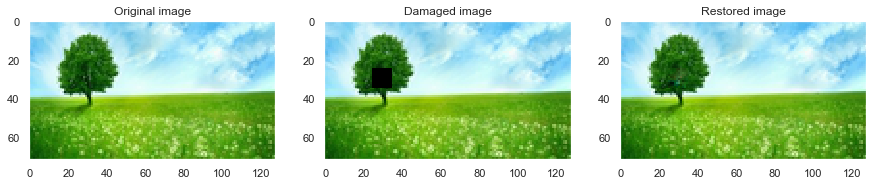

In [104]:
Inpainting ( "img11.jpg" , h=11 , stride=7 , alpha=1e-4 , i=25 , j=25 , width=10 , height=10 )

image shape :  (368, 376, 3)
dictionary shape :  (5043, 1932)
iteration  0  len b_pixel :  320
selected pixel :  (204, 309)
selected patch shape :  (5043,)
number of none zero components: 4.61  %
iteration  1  len b_pixel :  319
selected pixel :  (204, 288)
selected patch shape :  (5043,)
number of none zero components: 6.42  %
iteration  2  len b_pixel :  319
selected pixel :  (124, 309)
selected patch shape :  (5043,)
number of none zero components: 3.73  %
iteration  3  len b_pixel :  318
selected pixel :  (145, 309)
selected patch shape :  (5043,)
number of none zero components: 3.16  %
iteration  4  len b_pixel :  318
selected pixel :  (178, 309)
selected patch shape :  (5043,)
number of none zero components: 2.69  %
iteration  5  len b_pixel :  277
selected pixel :  (204, 229)
selected patch shape :  (5043,)
number of none zero components: 4.09  %
iteration  6  len b_pixel :  276
selected pixel :  (204, 259)
selected patch shape :  (5043,)
number of none zero components: 6.21  %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration  15  len b_pixel :  68
selected pixel :  (174, 267)
selected patch shape :  (5043,)
number of none zero components: 5.07  %
elapsed time: 371.32 seconds


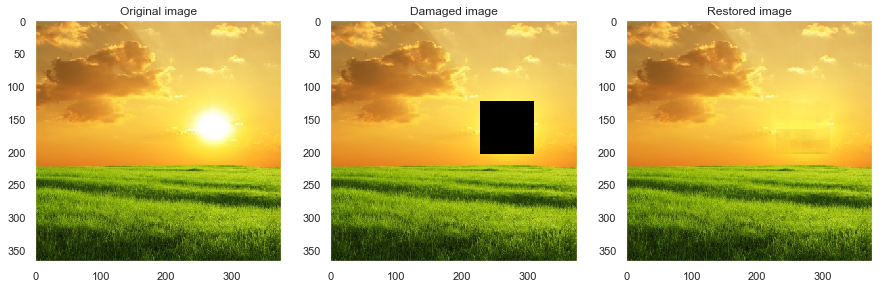

In [112]:
Inpainting ( "img3.jpg" , h=41 , stride=7 , alpha=1e-4 , i=124 , j=229 , width=81 , height=81, max_iter = 5000, verbose = True)

image shape :  (72, 128, 3)
dictionary shape :  (363, 4572)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


elapsed time: 197.99 seconds


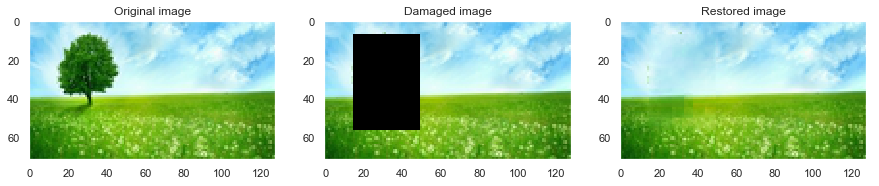

In [105]:
Inpainting ( "img11.jpg" , h=11 , stride=1 , alpha=0.0001 , i=7 , j=15 , width=35 , height=50, max_iter = 5000, verbose = False)

### The role of the parameter alpha:

Comme alpha contrôle le nombre de composantes non nulles, nous constatons qu’il contribue de manière significative aux résultats finaux. Si nous augmentons l'alpha, nous faisons l'hypothèse que seuls quelques patches de notre dictionnaire sont nécessaires pour représenter cette région manquante.
Par conséquent, à chaque itération, nous sélectionnons presque une couleur et l’utilisons pour remplir notre région . comme indiqué dans les résultats 3.

Par contre, si alpha est réduit à 0, nous obtenons des patches totalement différents qui vont à l'encontre de la prédiction de la partie manquante. Par exemple, dans les premiers résultats ci-dessous, nous voyons des régions du ciel remplies de vert! Cela montre que lors de l'apprentissage , certains patches de la région verte ont été considérés comme pertinents pour cet endroit, alors qu'ils ne le sont pas.
<br>

image shape :  (72, 128, 3)
dictionary shape :  (363, 4572)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


elapsed time: 43.19 seconds


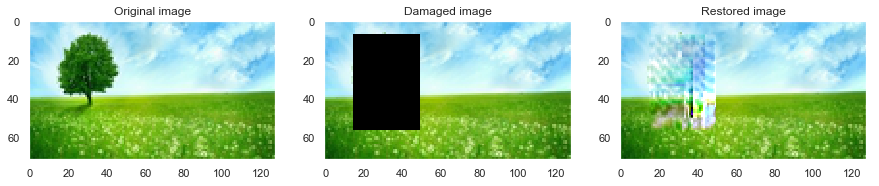

In [113]:
Inpainting ( "img11.jpg" , h=11 , stride=1 , alpha=0 , i=7 , j=15 , width=35 , height=50, max_iter = 5000, verbose = False)

image shape :  (72, 128, 3)
dictionary shape :  (363, 4572)
elapsed time: 78.62 seconds


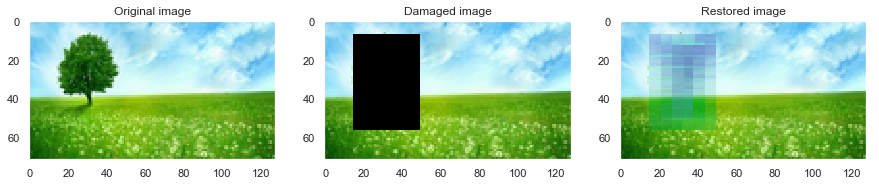

In [114]:
Inpainting ( "img11.jpg" , h=11 , stride=1 , alpha=0.01 , i=7 , j=15 , width=35 , height=50, max_iter = 5000, verbose = False)

image shape :  (72, 128, 3)
dictionary shape :  (363, 4572)
elapsed time: 6.22 seconds


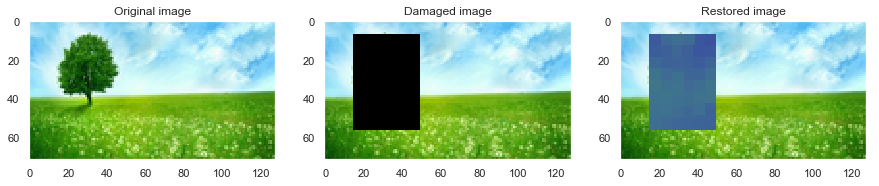

In [115]:
Inpainting ( "img11.jpg" , h=11 , stride=1 , alpha=1 , i=7 , j=15 , width=35 , height=50, max_iter = 5000, verbose = False)

### Noise removal:

Noise removal is a much easier task than removing a missing region because we do not have a continuous set of missing pixels, which means that we are less likely to mess up the geometry of objects in the image. Apart from this, the noise suppression proceeds exactly as the previous process on the missing regions. The only issue that can occur is the fact that we can now end up with an empty dictionary because the picture is very noisy , nd that's due to the lack of intact patches , because the holes could be separated by 2 pixels or less anywhere in the image.
Therefore, this algorithm is not well adapted to denoising, as mentioned in the paper [1] "inpainting is not débruiting"


image shape :  (368, 376, 3)
noise percent confirmation :  0.24933510638297873  %
noise percent confirmation :  0.24933510638297873  %
dictionary shape :  (1323, 1746)
iteration  0  len b_pixel :  345
selected pixel :  (246, 169)
selected patch shape :  (1323,)
number of none zero components: 27.49  %
iteration  1  len b_pixel :  344
selected pixel :  (194, 139)
selected patch shape :  (1323,)
number of none zero components: 17.53  %
iteration  2  len b_pixel :  343
selected pixel :  (281, 150)
selected patch shape :  (1323,)
number of none zero components: 29.90  %
iteration  3  len b_pixel :  342
selected pixel :  (234, 163)
selected patch shape :  (1323,)
number of none zero components: 28.06  %
iteration  4  len b_pixel :  340
selected pixel :  (143, 293)
selected patch shape :  (1323,)
number of none zero components: 27.72  %
iteration  5  len b_pixel :  338
selected pixel :  (246, 239)
selected patch shape :  (1323,)
number of none zero components: 29.27  %
iteration  6  len b_pi

iteration  60  len b_pixel :  216
selected pixel :  (167, 210)
selected patch shape :  (1323,)
number of none zero components: 24.80  %
iteration  61  len b_pixel :  213
selected pixel :  (149, 201)
selected patch shape :  (1323,)
number of none zero components: 18.84  %
iteration  62  len b_pixel :  211
selected pixel :  (139, 129)
selected patch shape :  (1323,)
number of none zero components: 20.16  %
iteration  63  len b_pixel :  208
selected pixel :  (158, 270)
selected patch shape :  (1323,)
number of none zero components: 39.75  %
iteration  64  len b_pixel :  205
selected pixel :  (239, 291)
selected patch shape :  (1323,)
number of none zero components: 27.55  %
iteration  65  len b_pixel :  202
selected pixel :  (238, 307)
selected patch shape :  (1323,)
number of none zero components: 26.92  %
iteration  66  len b_pixel :  199
selected pixel :  (251, 310)
selected patch shape :  (1323,)
number of none zero components: 30.99  %
iteration  67  len b_pixel :  198
selected pixel

iteration  121  len b_pixel :  41
selected pixel :  (214, 301)
selected patch shape :  (1323,)
number of none zero components: 27.66  %
iteration  122  len b_pixel :  37
selected pixel :  (215, 288)
selected patch shape :  (1323,)
number of none zero components: 27.61  %
iteration  123  len b_pixel :  34
selected pixel :  (226, 291)
selected patch shape :  (1323,)
number of none zero components: 30.41  %
iteration  124  len b_pixel :  33
selected pixel :  (142, 140)
selected patch shape :  (1323,)
number of none zero components: 18.33  %
iteration  125  len b_pixel :  29
selected pixel :  (132, 245)
selected patch shape :  (1323,)
number of none zero components: 22.91  %
iteration  126  len b_pixel :  24
selected pixel :  (220, 263)
selected patch shape :  (1323,)
number of none zero components: 28.35  %
iteration  127  len b_pixel :  19
selected pixel :  (162, 132)
selected patch shape :  (1323,)
number of none zero components: 16.67  %
iteration  128  len b_pixel :  14
selected pixel

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration  131  len b_pixel :  1
selected pixel :  (209, 223)
selected patch shape :  (1323,)
number of none zero components: 17.30  %
elapsed time: 1068.14 seconds


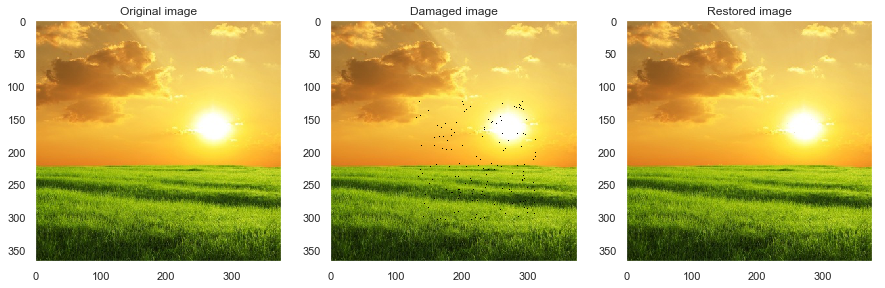

In [132]:
Inpainting ( "img3.jpg" , h=21 , stride=7 , alpha=1e-5 , i=124 , j=229 , width=81 , height=81, max_iter = 5000, Noise = True, noise_per = 0.01)

image shape :  (368, 376, 3)
dictionary shape :  (2883, 1490)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


elapsed time: 1626.84 seconds


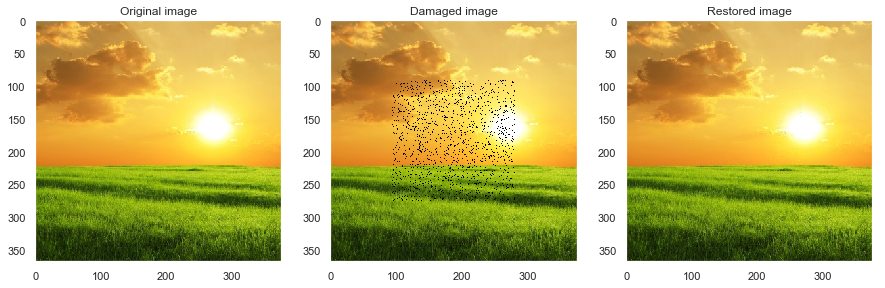

In [138]:
Inpainting ( "img3.jpg" , h=31 , stride=7 , alpha=1e-4 , i=124 , j=229 , width=81 , height=81, max_iter = 5000, Noise = True, noise_per = 0.08, verbose = False)

image shape :  (72, 128, 3)
dictionary shape :  (363, 91)
iteration  0  len b_pixel :  184
selected pixel :  (12, 22)
selected patch shape :  (363,)
number of none zero components: 5.49  %
iteration  1  len b_pixel :  182
selected pixel :  (47, 84)
selected patch shape :  (363,)
number of none zero components: 6.59  %
iteration  2  len b_pixel :  179
selected pixel :  (13, 35)
selected patch shape :  (363,)
number of none zero components: 7.69  %
iteration  3  len b_pixel :  175
selected pixel :  (16, 29)
selected patch shape :  (363,)
number of none zero components: 6.59  %
iteration  4  len b_pixel :  172
selected pixel :  (46, 52)
selected patch shape :  (363,)
number of none zero components: 6.59  %
iteration  5  len b_pixel :  168
selected pixel :  (20, 21)
selected patch shape :  (363,)
number of none zero components: 5.49  %
iteration  6  len b_pixel :  164
selected pixel :  (41, 83)
selected patch shape :  (363,)
number of none zero components: 5.49  %
iteration  7  len b_pixel

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


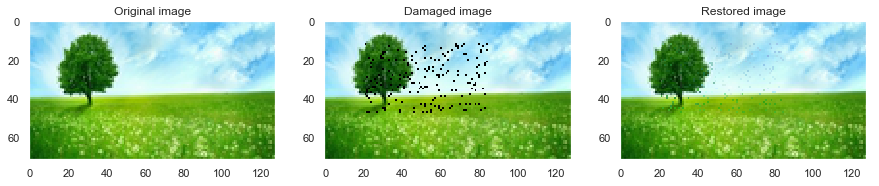

In [162]:
Inpainting ( "img11.jpg" , h= 11, stride=7 , alpha=1e-2 , i=124 , j=229 , width=81 , height=81, max_iter = 5000, Noise = True, noise_per = 0.08, verbose = True)

### Patch priorities:


Finding the order in which we choose the patch to fill is crucial and fundamental . The paper [2] of Figure 3 showed how different filling orders give different results. Many approaches to this problem use different metrics to choose the best candidate patch. In our approach, we chose the patch that has fewer missing pixels. The reason behind this is to ensure more learning examples for Lasso regression and thus avoid under-fitting.

In addition, we made sure that the extreme case of this approach does not pose a problem. In other words, even with 1 pixel missing in the chosen patch, we can not overfit because we have a regularization term.

### Conclusion:

The algorithm proposed by this paper is a very good **Classical Machine Learning algorithm** that accomplishes the task of Inpainting.

**Advantages** :
+ It gives very good results that are realistic for us, we just have to make a good tuning of the parameters
+ Even if in the article it is said that it is not made for the suppression of noise, but we could test it and apply it to Noise and it works well because each pixel or small group of pixels will be considered as a missing region to tackle !
+ Simple model to understand, intuitive and interpretable.

**Disadvantages**:

- It is very slow in execution even with small images (300, 300) compared to the images of our time in 2019, it has therefore a mediocre complexity .
- The higher the resolution of the image as well as its quality, the more the results are bad
- Several parameters for tuning for example: h, stride, alpha, max_iter, ... , which complicates the task to get the best fitting


### References:

[1] Bin Shen and Wei Hu and Zhang, Yimin and Zhang, Yu-Jin, Image Inpainting via Sparse Representation Proceedings of the 2009 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP ’09)

[2] Julien Mairal Sparse coding and Dictionnary Learning for Image Analysis INRIA Visual Recognition and Machine Learning Summer School, 2010

[3] A. Criminisi, P. Perez, K. Toyama Region Filling and Object Removal by Exemplar-Based Image Inpainting IEEE Transaction on Image Processing (Vol 13-9), 2004